<a href="https://colab.research.google.com/github/superbunny38/Projects/blob/main/Competitions/Dacon/Predict_abalone_age/Predict_abalone_age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DACON 전복 나이 예측 경진대회


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/2022/data.zip"

Archive:  /content/drive/MyDrive/2022/data.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [ ]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [ ]:
pwd

'/content'

# Data 확인

In [ ]:
original_train = pd.read_csv("/content/data/train.csv")

In [ ]:
original_train.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,1,M,0.605,0.470,0.115,1.114,0.393,0.291,0.310,15
1,2,I,0.430,0.315,0.095,0.378,0.175,0.080,0.104,8
2,3,I,0.580,0.490,0.195,1.317,0.530,0.254,0.410,18
3,4,M,0.535,0.405,0.175,1.270,0.548,0.327,0.337,13
4,5,I,0.310,0.235,0.090,0.127,0.048,0.031,0.040,6


In [ ]:
train_df = original_train

In [ ]:
original_train.shape

(1253, 10)

# EDA

**Categorical Data Encoding**

In [ ]:
class_mapping = {label:idx for idx,label in enumerate(np.unique(train_df['Gender']))}
class_mapping

{'F': 0, 'I': 1, 'M': 2}

In [ ]:
train_df['Gender'] = train_df['Gender'].map(class_mapping)

In [ ]:
train_df.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,1,2,0.605,0.470,0.115,1.114,0.393,0.291,0.310,15
1,2,1,0.430,0.315,0.095,0.378,0.175,0.080,0.104,8
2,3,1,0.580,0.490,0.195,1.317,0.530,0.254,0.410,18
3,4,2,0.535,0.405,0.175,1.270,0.548,0.327,0.337,13
4,5,1,0.310,0.235,0.090,0.127,0.048,0.031,0.040,6


**누락된 값 확인**



In [ ]:
original_train.isnull().sum()

id                0
Gender            0
Lenght            0
Diameter          0
Height            0
Whole Weight      0
Shucked Weight    0
Viscra Weight     0
Shell Weight      0
Target            0
dtype: int64

## Target Value Analysis

In [ ]:
#descriptive statistics summary
train_df['Target'].describe()

count   1253.000
mean       9.912
std        3.215
min        3.000
25%        8.000
50%       10.000
75%       11.000
max       29.000
Name: Target, dtype: float64

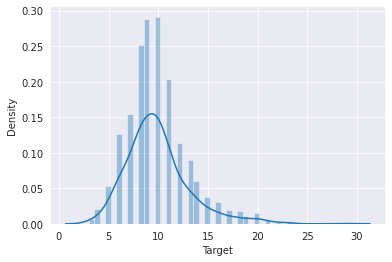

In [ ]:
sns.distplot(train_df["Target"])

In [ ]:
train_df.columns

Index(['id', 'Gender', 'Lenght', 'Diameter', 'Height', 'Whole Weight',
       'Shucked Weight', 'Viscra Weight', 'Shell Weight', 'Target'],
      dtype='object')

**drop "id" column**

In [ ]:
train_df = train_df.drop("id",axis = 1)

In [ ]:
len(train_df.columns)

9

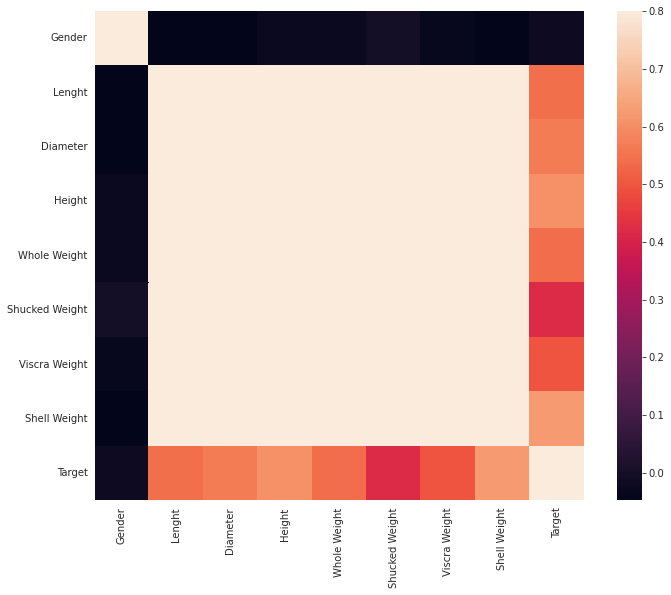

In [ ]:
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

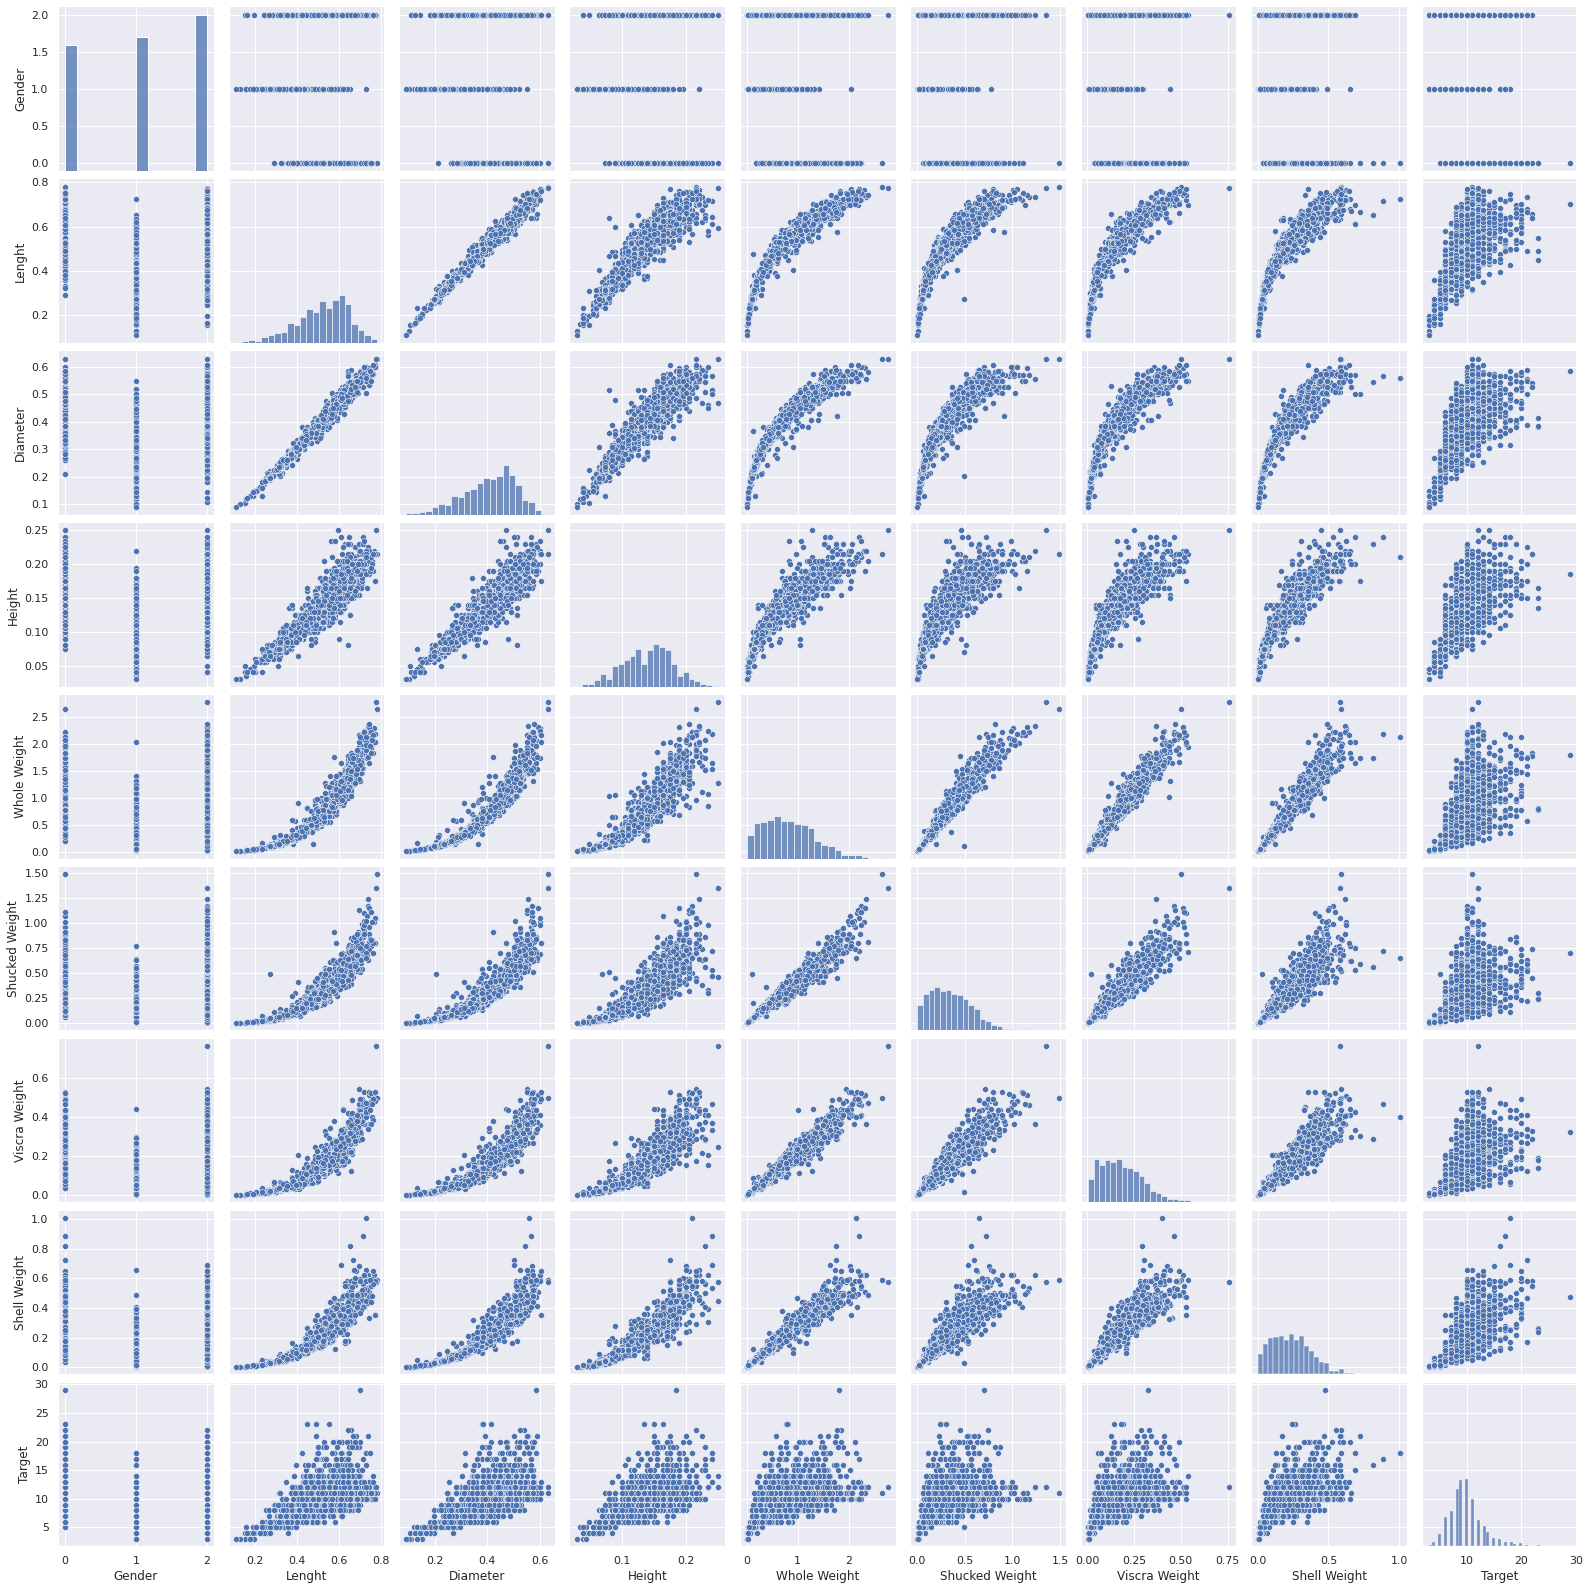

In [ ]:
#scatterplot
sns.set()
cols = train_df.columns
sns.pairplot(train_df[cols], size = 2.5)
plt.show();

**Drop outliers**

In [ ]:
cols = train_df.columns
cols = cols[:-1]
cols

Index(['Gender', 'Lenght', 'Diameter', 'Height', 'Whole Weight',
       'Shucked Weight', 'Viscra Weight', 'Shell Weight'],
      dtype='object')

Lenght


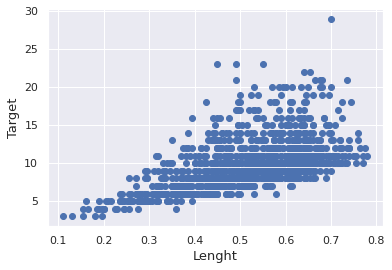

In [ ]:
print(cols[1])
fig, ax = plt.subplots()
ax.scatter(x = train_df[cols[1]], y = train_df['Target'])
plt.ylabel('Target', fontsize=13)
plt.xlabel(cols[1], fontsize=13)
plt.show()#one outlier detected

In [ ]:
#Deleting outliers
train_df = train_df.drop(train_df[(train_df[cols[1]]>0.6) & (train_df['Target']>25)].index)

Lenght


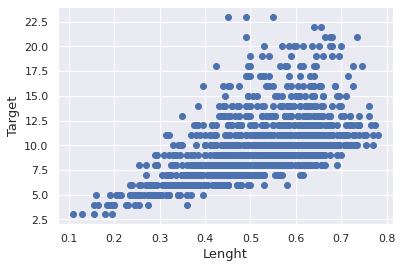

In [ ]:
#check
print(cols[1])
fig, ax = plt.subplots()
ax.scatter(x = train_df[cols[1]], y = train_df['Target'])
plt.ylabel('Target', fontsize=13)
plt.xlabel(cols[1], fontsize=13)
plt.show()

Diameter


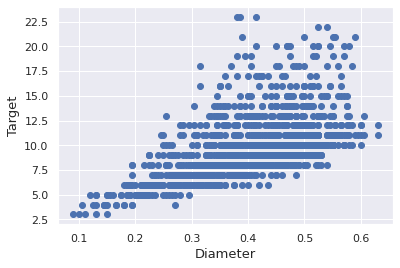

In [ ]:
i = 2
print(cols[i])
fig, ax = plt.subplots()
ax.scatter(x = train_df[cols[i]], y = train_df['Target'])
plt.ylabel('Target', fontsize=13)
plt.xlabel(cols[i], fontsize=13)
plt.show()#no outlier detected

Height


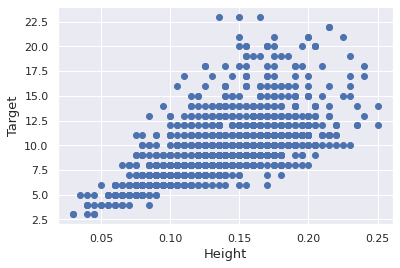

In [ ]:
i = 3
print(cols[i])
fig, ax = plt.subplots()
ax.scatter(x = train_df[cols[i]], y = train_df['Target'])
plt.ylabel('Target', fontsize=13)
plt.xlabel(cols[i], fontsize=13)
plt.show()#no outlier detected

Whole Weight


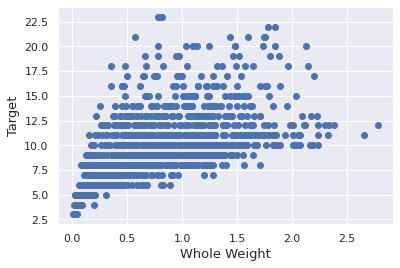

In [ ]:
i = 4
print(cols[i])
fig, ax = plt.subplots()
ax.scatter(x = train_df[cols[i]], y = train_df['Target'])
plt.ylabel('Target', fontsize=13)
plt.xlabel(cols[i], fontsize=13)
plt.show()#no outlier detected

Shucked Weight


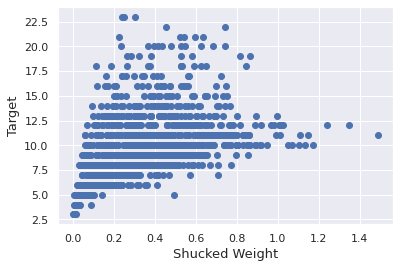

In [ ]:
i = 5
print(cols[i])
fig, ax = plt.subplots()
ax.scatter(x = train_df[cols[i]], y = train_df['Target'])
plt.ylabel('Target', fontsize=13)
plt.xlabel(cols[i], fontsize=13)
plt.show()#two outlier detected

In [ ]:
#Deleting outliers
train_df = train_df.drop(train_df[(train_df[cols[i]]>1.3) & (train_df['Target']>10)].index)

Shucked Weight


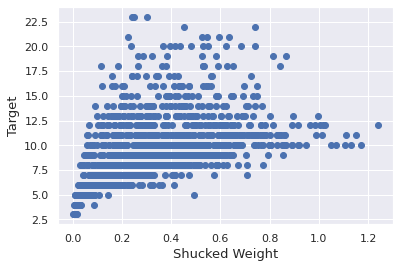

In [ ]:
#check
i = 5
print(cols[i])
fig, ax = plt.subplots()
ax.scatter(x = train_df[cols[i]], y = train_df['Target'])
plt.ylabel('Target', fontsize=13)
plt.xlabel(cols[i], fontsize=13)
plt.show()#two outlier detected

Viscra Weight


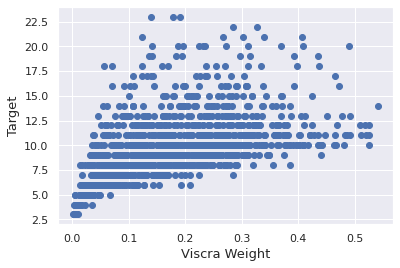

In [ ]:
i = 6
print(cols[i])
fig, ax = plt.subplots()
ax.scatter(x = train_df[cols[i]], y = train_df['Target'])
plt.ylabel('Target', fontsize=13)
plt.xlabel(cols[i], fontsize=13)
plt.show()#no outlier detected

Shell Weight


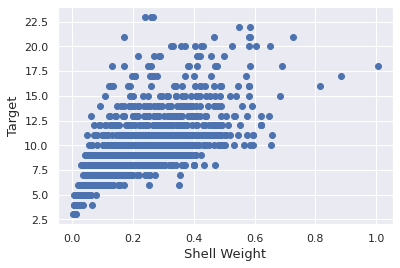

In [ ]:
i = 7
print(cols[i])
fig, ax = plt.subplots()
ax.scatter(x = train_df[cols[i]], y = train_df['Target'])
plt.ylabel('Target', fontsize=13)
plt.xlabel(cols[i], fontsize=13)
plt.show()#one outlier detected

In [ ]:
#Deleting outliers
train_df = train_df.drop(train_df[(train_df[cols[i]]>1.0) & (train_df['Target']>16)].index)

Shell Weight


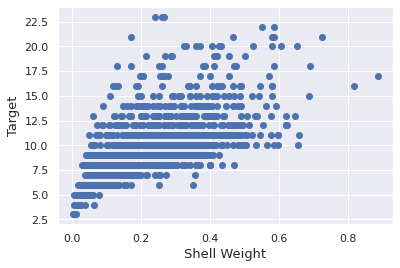

In [ ]:
#check
i = 7
print(cols[i])
fig, ax = plt.subplots()
ax.scatter(x = train_df[cols[i]], y = train_df['Target'])
plt.ylabel('Target', fontsize=13)
plt.xlabel(cols[i], fontsize=13)
plt.show()#one outlier detected

## Check the distribution of Target


 mu = 9.89 and sigma = 3.16



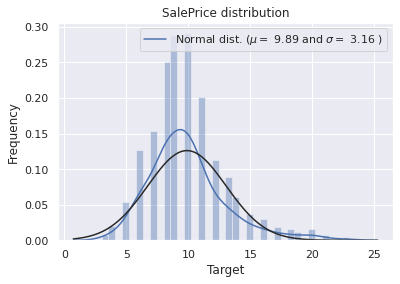

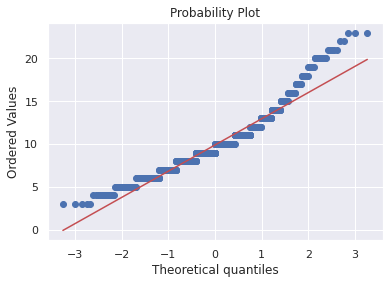

In [ ]:
sns.distplot(train_df['Target'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['Target'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['Target'], plot=plt)
plt.show()

right skewed data -> need to transform this variable and make it more normally distributed.


 mu = 2.35 and sigma = 0.28



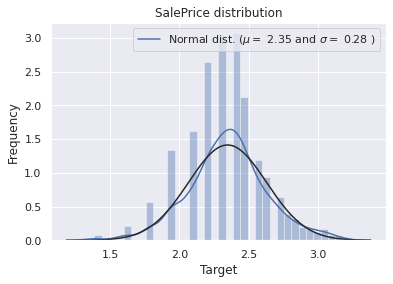

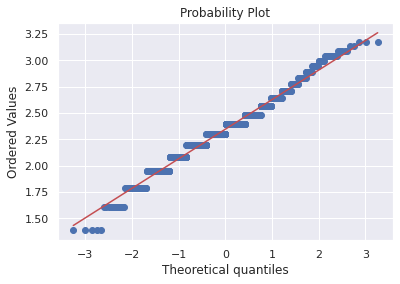

In [ ]:
#Log-transformation of the target variable
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df["Target"] = np.log1p(train_df["Target"])

#Check the new distribution 
sns.distplot(train_df['Target'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df["Target"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['Target'], plot=plt)
plt.show()

## Feature Engineering

In [ ]:
original_test = pd.read_csv("/content/data/test.csv")
original_test.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight
0,1,F,0.595,0.470,0.155,1.121,0.452,0.178,0.155
1,2,M,0.580,0.450,0.150,0.927,0.276,0.181,0.360
2,3,I,0.260,0.205,0.070,0.097,0.042,0.019,0.030
3,4,M,0.590,0.460,0.130,1.102,0.455,0.205,0.330
4,5,F,0.595,0.465,0.140,1.113,0.517,0.244,0.305


In [ ]:
test_df = original_test
test_df['Gender'] = original_test['Gender'].map(class_mapping)

In [ ]:
test_df = test_df.drop("id",axis = 1)

In [ ]:
test_df.head()

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight
0,0,0.595,0.470,0.155,1.121,0.452,0.178,0.155
1,2,0.580,0.450,0.150,0.927,0.276,0.181,0.360
2,1,0.260,0.205,0.070,0.097,0.042,0.019,0.030
3,2,0.590,0.460,0.130,1.102,0.455,0.205,0.330
4,0,0.595,0.465,0.140,1.113,0.517,0.244,0.305


In [ ]:
original_train.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,1,2,0.605,0.470,0.115,1.114,0.393,0.291,0.310,15
1,2,1,0.430,0.315,0.095,0.378,0.175,0.080,0.104,8
2,3,1,0.580,0.490,0.195,1.317,0.530,0.254,0.410,18
3,4,2,0.535,0.405,0.175,1.270,0.548,0.327,0.337,13
4,5,1,0.310,0.235,0.090,0.127,0.048,0.031,0.040,6


In [ ]:
train_df.head()

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,2,0.605,0.470,0.115,1.114,0.393,0.291,0.310,2.773
1,1,0.430,0.315,0.095,0.378,0.175,0.080,0.104,2.197
2,1,0.580,0.490,0.195,1.317,0.530,0.254,0.410,2.944
3,2,0.535,0.405,0.175,1.270,0.548,0.327,0.337,2.639
4,1,0.310,0.235,0.090,0.127,0.048,0.031,0.040,1.946


In [ ]:
np.expm1(train_df["Target"])

0      15.000
1       8.000
2      18.000
3      13.000
4       6.000
        ...  
1248    4.000
1249    7.000
1250    7.000
1251    6.000
1252   11.000
Name: Target, Length: 1249, dtype: float64

## Data preparation for training

In [ ]:
y_train = train_df["Target"]
real_train = train_df.drop("Target", axis = 1)

In [ ]:
pd.DataFrame(y_train).to_csv("y_train.csv", index = False)
pd.DataFrame(real_train).to_csv("real_train.csv", index = False)

# Modeling

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
real_train.values

array([[2.    , 0.605 , 0.47  , ..., 0.3925, 0.291 , 0.31  ],
       [1.    , 0.43  , 0.315 , ..., 0.175 , 0.08  , 0.1045],
       [1.    , 0.58  , 0.49  , ..., 0.5305, 0.254 , 0.41  ],
       ...,
       [0.    , 0.525 , 0.41  , ..., 0.416 , 0.163 , 0.18  ],
       [0.    , 0.445 , 0.335 , ..., 0.2025, 0.1095, 0.1195],
       [0.    , 0.75  , 0.55  , ..., 0.83  , 0.366 , 0.44  ]])

k-fold validation

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(real_train.values)
    rmse= np.sqrt(-cross_val_score(model, real_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

models

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

## Base Models Scores

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1878 (0.0154)



In [ ]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1877 (0.0154)



In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1863 (0.0148)



In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1957 (0.0160)



In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1825 (0.0160)



In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1990 (0.0156)



# Grid Search

In [ ]:
n_folds = 5

def rmsle(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
from sklearn.model_selection import GridSearchCV
#가장 좋아 보이는 xgboost 사용

params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(4,11)], 'max_depth': [2,3,4], 'reg_lambda':[i/10.0 for i in range(7,9)], 'reg_alpha':[i/10.0 for i in range(4,7)]}

model = xgb.XGBRegressor(nthread=-1) 

grid = GridSearchCV(model, params)
grid.fit(real_train.values, y_train)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[11:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:lin

GridSearchCV(estimator=XGBRegressor(nthread=-1),
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                              1.0],
                         'gamma': [0.3, 0.4, 0.5], 'max_depth': [2, 3, 4],
                         'min_child_weight': [4, 5],
                         'reg_alpha': [0.4, 0.5, 0.6], 'reg_lambda': [0.7, 0.8],
                         'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]})

In [ ]:
xgb_train_pred = grid.best_estimator_.predict(real_train.values)
xgb_pred = grid.best_estimator_.predict(test_df.values)
print(rmsle(y_train, xgb_train_pred))

0.16334263597674073


In [ ]:
best_xgb = grid.best_estimator_

In [ ]:
submission4 = np.expm1(best_xgb.predict(test_df.values))

In [ ]:
ids = np.arange(1,len(submission4)+1)
len(ids)

2924

In [ ]:
submission4_df = pd.DataFrame({"id":ids, "Target":submission4})
submission4_df

,id,Target
0,1,8.351
1,2,12.735
2,3,5.674
3,4,10.496
4,5,10.026
...,...,...
2919,2920,4.067
2920,2921,7.307
2921,2922,9.249
2922,2923,9.261


In [ ]:
submission4_df.to_csv("submission4.csv",index=False)